## MNIST Classification, Hybrid QNNs

In [1]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [2]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [3]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
# manual_seed(42)

batch_size = 10
n_samples = 1000  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

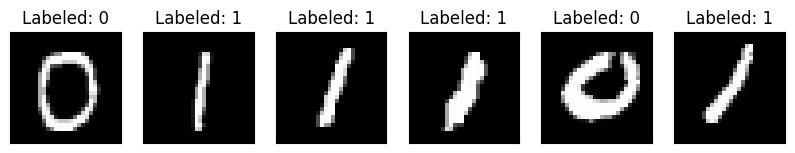

In [4]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [5]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [6]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [7]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

In [8]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -1.0522
Training [20%]	Loss: -1.4753
Training [30%]	Loss: -1.7682
Training [40%]	Loss: -2.0127
Training [50%]	Loss: -2.2389
Training [60%]	Loss: -2.4461
Training [70%]	Loss: -2.6553
Training [80%]	Loss: -2.8575
Training [90%]	Loss: -3.0728
Training [100%]	Loss: -3.2770


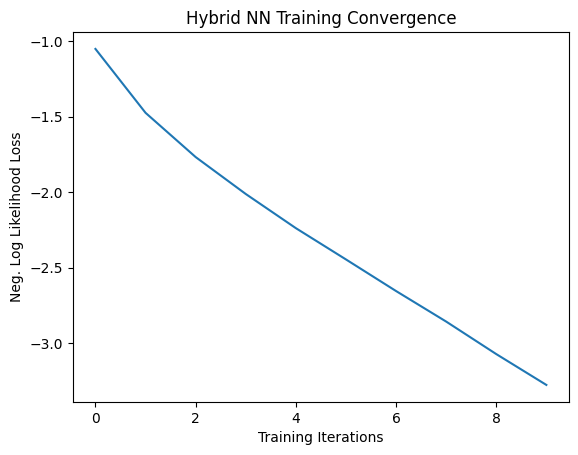

In [9]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [10]:
torch.save(model4.state_dict(), "model5.pt")

In [11]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model5.pt"))

<All keys matched successfully>

In [12]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -3.2810
	Accuracy: 100.0%


In [1]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(transforms.functional.resize(data,size = (5))[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

NameError: name 'plt' is not defined

In [14]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
from absl import app, flags
from easydict import EasyDict

In [15]:
# Evaluate on clean and adversarial data
model5.eval()
report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0)
for batch_idx, (data, target) in enumerate(test_loader):
    x_fgm = fast_gradient_method(model5, data, epochs, np.inf)
    x_pgd = projected_gradient_descent(model5, data, epochs, 0.01, 40, np.inf)
    y_pred = model5(data).argmax(dim=1, keepdim=True)  # model prediction on clean examples
    y_pred_fgm = model5(x_fgm).argmax(dim=1, keepdim=True)  # model prediction on FGM adversarial examples
    y_pred_pgd = model5(x_pgd).argmax(dim=1, keepdim=True)  # model prediction on PGD adversarial examples
    # report.nb_test += target.size(0)
    report.correct += y_pred.eq(target.view_as(y_pred)).sum().item()
    report.correct_fgm += y_pred_fgm.eq(target.view_as(y_pred_fgm)).sum().item()
    report.correct_pgd += y_pred_pgd.eq(target.view_as(y_pred_pgd)).sum().item()
print(
    "test acc on clean examples (%): {:.3f}".format(
        report.correct / len(test_loader) / batch_size * 100
    )
)
print(
    "test acc on FGM adversarial examples (%): {:.3f}".format(
        report.correct_fgm / len(test_loader) / batch_size * 100
    )
)
print(
    "test acc on PGD adversarial examples (%): {:.3f}".format(
        report.correct_pgd / len(test_loader) / batch_size * 100
    )
)

test acc on clean examples (%): 100.000
test acc on FGM adversarial examples (%): 63.000
test acc on PGD adversarial examples (%): 2.000


In [16]:
print(len(test_loader))
report.correct / len(test_loader) / batch_size

10


1.0

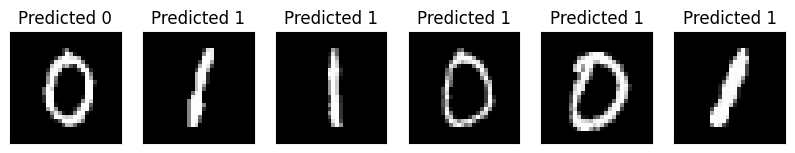

In [17]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))
model5.eval()
# with no_grad():
for batch_idx, (data, target) in enumerate(test_loader):
    if count == n_samples_show:
        break
    x_fgm = fast_gradient_method(model5, data, epochs, np.inf)
    # x_pgd = projected_gradient_descent(model5, data, epochs, 0.01, 40, np.inf)
    # y_pred = model5(data).argmax(dim=1, keepdim=True)  # model prediction on clean examples
    output = model5(x_fgm[0:1])  # model prediction on FGM adversarial examples
    # y_pred_pgd = model5(x_pgd).argmax(dim=1, keepdim=True)  # model prediction on PGD adversarial examples
    # output = model5(data[0:1])
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)

    pred = output.argmax(dim=1, keepdim=True)

    axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

    axes[count].set_xticks([])
    axes[count].set_yticks([])
    axes[count].set_title("Predicted {}".format(pred.item()))

    count += 1

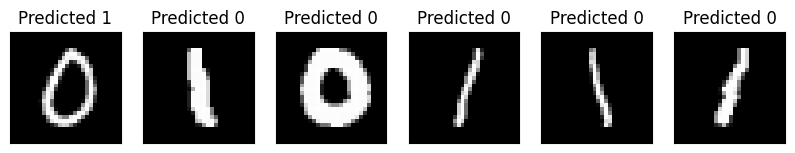

In [18]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))
model5.eval()
# with no_grad():
for batch_idx, (data, target) in enumerate(test_loader):
    if count == n_samples_show:
        break
    # x_fgm = fast_gradient_method(model5, data, epochs, np.inf)
    x_pgd = projected_gradient_descent(model5, data, epochs, 0.01, 40, np.inf)
    # y_pred = model5(data).argmax(dim=1, keepdim=True)  # model prediction on clean examples
    output = model5(x_pgd[0:1])  # model prediction on FGM adversarial examples
    # y_pred_pgd = model5(x_pgd).argmax(dim=1, keepdim=True)  # model prediction on PGD adversarial examples
    # output = model5(data[0:1])
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)

    pred = output.argmax(dim=1, keepdim=True)

    axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

    axes[count].set_xticks([])
    axes[count].set_yticks([])
    axes[count].set_title("Predicted {}".format(pred.item()))

    count += 1